ZVAR Data Analysis Notebook

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import glob as glob
import fpw
import pandas as pd
from astropy import time, coordinates as coord, units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from scipy.stats import median_abs_deviation
from astropy.timeseries import LombScargle
from penquins import Kowalski
import json
import h5py
from datetime import datetime
import time as tme
import os
from astropy.table import Table
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VariabilityCandidate:
    def __init__(self, psid, ra, dec, valid, freq, fap, best_M, gaia_G, gaia_BP, gaia_RP, gaia_parallax, gaia_MG, gaia_BP_RP):
        self.id = psid
        self.ra = ra
        self.dec = dec
        self.valid = valid
        self.freq = freq
        self.fap = fap
        self.best_M = best_M
        self.gaia_G = gaia_G
        self.gaia_BP = gaia_BP
        self.gaia_RP = gaia_RP
        self.gaia_parallax = gaia_parallax
        self.gaia_MG = gaia_MG
        self.gaia_BP_RP = gaia_BP_RP


def process_curve(ra, dec, times, mags, magerrs):
    times = np.array(times)
    mags = np.array(mags)
    magerrs = np.array(magerrs)

    valid_indices = ~np.isnan(times)
    times = times[valid_indices]
    mags = mags[valid_indices]
    magerrs = magerrs[valid_indices]

    skycoord = coord.SkyCoord(ra, dec,
                            unit=(u.deg, u.deg), frame='icrs')
    palomar = coord.EarthLocation.of_site('Palomar')
    times = time.Time(np.array(times), format='mjd', scale='utc', location=palomar)
    ltt_bary = times.light_travel_time(skycoord) #Calculate light travel time
    barycorr_times = (times.tdb + ltt_bary).value #Add on the light travel time
    barycorr_times = barycorr_times - 2400000.5 #Convert from JD to BJD
    barycorr_times *= 86400 #Convert from BJD to BJS
    barycorr_times += 15 #midpoint correct ZTF timestamps
    barycorr_times -= np.min(barycorr_times) #Subtract off the zero point (ephemeris may be added later)

    #Convert mags to flux values
    mags = np.array(mags)
    magerrs = np.array(magerrs)
    med_mag = np.median(mags)

    flux = 10**(0.4*(med_mag - mags)) - 1.0
    ferrs = magerrs/1.086

    #Set nan values to zero
    flux[np.isnan(flux)] = 0
    ferrs[flux == 0] = np.inf
    
    #Basic MAD clip
    valid = np.where(np.abs(flux) < 5 * 1.483 * median_abs_deviation(flux))

    barycorr_times = barycorr_times[valid]
    flux = flux[valid]
    ferrs = ferrs[valid]

    flux -= np.mean(flux)

    return barycorr_times, flux, ferrs


def remove_deep_drilling(barycorr_times, flux, ferrs):
    dt = 40.0  # seconds
    znew_times, znew_flux, znew_ferrs = [], [], []

    unique_days = np.unique(np.floor(barycorr_times / 86400.0))
    for ud in unique_days:
        mask = (barycorr_times > ud * 86400.0) & (barycorr_times < (ud + 1.0) * 86400.0)
        zday_times = barycorr_times[mask]
        zday_flux = flux[mask]
        zday_ferrs = ferrs[mask]
        Nz = len(zday_times)

        # If more than 10 exposures in a night, check time sampling
        if Nz > 10:
            tsec = zday_times
            zdiff = ((tsec[1:] - tsec[:-1]) < dt)

            # Handle some edge cases
            if zdiff[0]:
                zdiff = np.insert(zdiff, 0, True)
            else:
                zdiff = np.insert(zdiff, 0, False)
            for j in range(1, len(zdiff)):
                if zdiff[j]:
                    zdiff[j - 1] = True

            # Only keep exposures with sampling > dt
            znew_times.append(zday_times[~zdiff])
            znew_flux.append(zday_flux[~zdiff])
            znew_ferrs.append(zday_ferrs[~zdiff])
        else:
            znew_times.append(zday_times)
            znew_flux.append(zday_flux)
            znew_ferrs.append(zday_ferrs)

    znew_times = np.concatenate(znew_times)
    znew_flux = np.concatenate(znew_flux)
    znew_ferrs = np.concatenate(znew_ferrs)

    return znew_times, znew_flux, znew_ferrs


def query_kowalski(k, ra, dec, min_epochs=50):
    query = {
        "query_type": "cone_search",
        "query": {
            "object_coordinates": {
                "cone_search_radius": 5,
                "cone_search_unit": "arcsec",
                "radec": {
                    'object': [
                        ra,
                        dec
                    ]
                }
            },
            "catalogs": {
                "ZTF_sources_20240117": {
                    "filter": {},
                    "projection": {
                        'data.hjd': 1,
                        'data.mag': 1,
                        'data.magerr': 1,
                        'data.ra': 1,
                        'data.dec': 1,
                        'data.fid': 1,
                        'data.programid': 1,
                        'data.catflags': 1,
                        'filter':1
                    }
                }
            }
        },
        "kwargs": {
            "filter_first": False
        }
    }

    start = tme.time()
    response = k.query(query=query)
    end = tme.time()
    data = response["default"].get("data")

    key = list(data.keys())[0]
    data = data[key]
    key = list(data.keys())[0]
    data = data[key]
    lightcurves = {}
    num_epochs = 0
    for datlist in data:
        objid = str(datlist["_id"])
        # print(datlist)
        ztf_filter = datlist["filter"]
        dat = datlist["data"]
        hjd, mag, magerr, coords_out, ztf_id, ztf_filt = [], [], [], [], [], []
        for dic in dat:
            if dic["catflags"]==0:
                hjd.append(dic["hjd"])
                mag.append(dic["mag"])
                magerr.append(dic["magerr"])
            coords_out.append(dic["ra"])
            coords_out.append(dic["dec"])
            ztf_id.append(objid)
            ztf_filt.append(ztf_filter)
        if len(hjd) < min_epochs: continue
        if len(hjd) > num_epochs:
            num_epochs = len(hjd)
            lightcurves["hjd"] = np.array(hjd)
            lightcurves["mag"] = np.array(mag)
            lightcurves["magerr"] = np.array(magerr)
            lightcurves["coords"] = np.array(coords_out)
            lightcurves['objid'] = objid
            lightcurves['filter'] = ztf_filter

        barycorr_times, flux, ferrs = process_curve(ra, dec, lightcurves['hjd'], lightcurves['mag'], lightcurves['magerr'])
        barycorr_times, flux, ferrs = remove_deep_drilling(barycorr_times, flux, ferrs)

        return barycorr_times, flux, ferrs


def freq_grid(t, fmin=None, fmax=None, oversample=3):
    trange = max(t) - min(t)
    texp = np.nanmin(np.diff(np.sort(t)))
    fres = 1./trange/oversample
    if fmax is None:
        fmax = 0.5 / texp
    if fmin is None:
        fmin = fres
    fgrid = np.arange(fmin,fmax,fres)
    return fgrid

def flag_terrestrial_freq(frequencies):
    """
    Function to identify and flag terrestrial frequencies
    from an array of frequency values.

    frequencies = numpy array of frequencies in Hz
    """
    # Define some standard frequencies in terms of Hz
    f_year = 0.002737803 / 86400  # Sidereal year (365.256363 days)
    f_lunar = 0.036600996 / 86400  # Lunar sidereal month (27.321661 days)
    f_day = 1.00273719 / 86400  # Sidereal day (23.9344696 hours)

    # List of frequency/width pairs indicating the
    # regions to be excluded from the frequencies array
    ef = np.array([
        (f_year, 0.00025 / 86400),  # 1 year
        (f_year / 2, 0.000125 / 86400),  # 2 year
        (f_year / 3, 0.0000835 / 86400),  # 3 year
        (f_year / 4, 0.0000625 / 86400),  # 4 year
        (f_year / 5, 0.0000500 / 86400),  # 5 year
        (f_year * 2, 0.00025 / 86400),  # 1/2 year
        (f_year * 3, 0.00025 / 86400),  # 1/3 year
        (f_year * 4, 0.00025 / 86400),  # 1/4 year
        (f_lunar, 0.005 / 86400),  # 1 lunar month
        (f_day, 0.05 / 86400),  # 1 day
        (f_day / 2, 0.02 / 86400),  # 2 day
        (f_day / 3, 0.01 / 86400),  # 3 day
        (f_day * 2, 0.05 / 86400),  # 1/2 day
        (f_day * 3, 0.05 / 86400),  # 1/3 day
        (f_day * 3 / 2, 0.02 / 86400),  # 2/3 day
        (f_day * 4 / 3, 0.02 / 86400),  # 3/4 day
        (f_day * 5 / 2, 0.02 / 86400),  # 2/5 day
        (f_day * 7 / 2, 0.02 / 86400),  # 2/7 day
        (f_day * 4, 0.05 / 86400),  # 1/4 day
        (f_day * 5, 0.05 / 86400),  # 1/5 day
        (f_day * 6, 0.05 / 86400),  # 1/6 day
        (f_day * 7, 0.05 / 86400),  # 1/7 day
        (f_day * 8, 0.05 / 86400),  # 1/8 day
        (f_day * 9, 0.05 / 86400),  # 1/9 day
        (f_day * 10, 0.05 / 86400)  # 1/10 day
    ])

    # Create array to store keep/discard indices
    keep_freq = np.ones(len(frequencies), dtype=int)

    # Vectorized operation to flag frequencies
    for center, width in ef:
        mask = (frequencies > center - width) & (frequencies < center + width)
        keep_freq[mask] = 0

    return keep_freq

In [3]:
band = 'r'
# cand_files = glob.glob(f'/data/zvar/variability_candidates/0279/*_z{band}.csv', recursive=True)
cand_files = glob.glob(f'/data/zvar/variability_candidates/0648/*_z{band}.csv', recursive=True)
cand_files += glob.glob(f'/data/zvar/variability_candidates/0649/*_z{band}.csv', recursive=True)
candidate_list = []
for file in cand_files:
    df = pd.read_csv(file)
    freqs = np.array([df['frequency_20'], df['frequency_10'], df['frequency_5']])
    faps = np.array([df['FAP_20'], df['FAP_10'], df['FAP_5']])
    for i in range(df.shape[0]):
        if df['best_M'][i] == 20:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[0, i], faps[0, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], df['MG'][i], df['BP_RP'][i]))
        if df['best_M'][i] == 10:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[1, i], faps[1, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], df['MG'][i], df['BP_RP'][i]))
        if df['best_M'][i] == 5:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[2, i], faps[2, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], df['MG'][i], df['BP_RP'][i]))

In [4]:
#Load a Gaia HR diagram
gaia_sample = Table.read("hrd_query_edr3_200pc.fits").to_pandas()
gaia_bprp = gaia_sample.phot_bp_mean_mag.values - gaia_sample.phot_rp_mean_mag.values
gaia_gmag = gaia_sample.phot_g_mean_mag.values + 5.0*np.log10(gaia_sample.parallax.values/100)

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


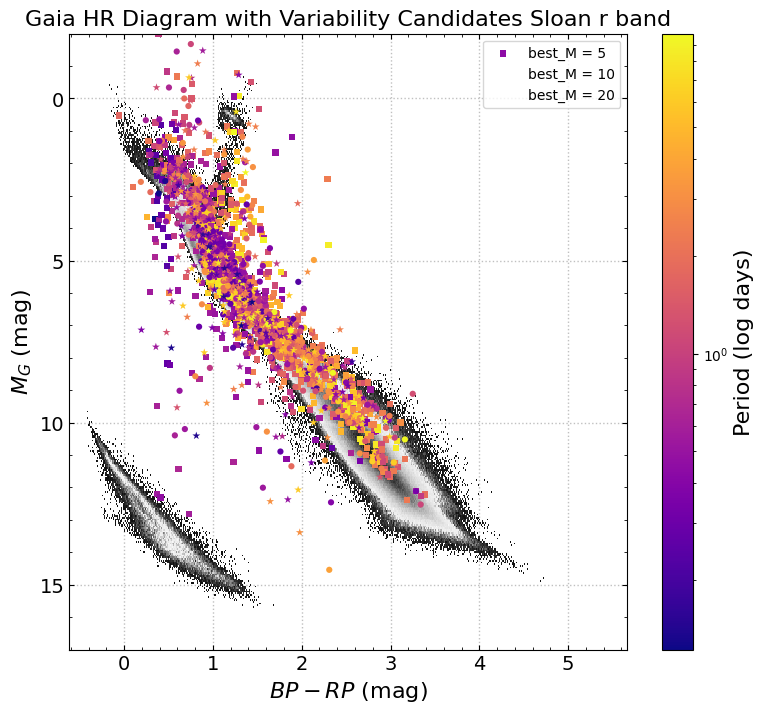

In [5]:
# Assuming candidate_list is already defined and contains the necessary data
periods = [1/candidate.freq for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]
bp_rp = [candidate.gaia_BP_RP for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]
mg = [candidate.gaia_MG for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]
best_M = [candidate.best_M for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]

# # Filter data to exclude objects with periods within 2 hours of 4 days
# filtered_indices = [i for i, period in enumerate(periods) if not (3.9167 <= period <= 4.0833)]
# periods = [periods[i] for i in filtered_indices]
# bp_rp = [bp_rp[i] for i in filtered_indices]
# mg = [mg[i] for i in filtered_indices]
# best_M = [best_M[i] for i in filtered_indices]

# Overplot candidates on the Gaia HR Diagram
figa = plt.figure('a', figsize=(9, 8))
gs = GridSpec(1, 1)
ax = figa.add_subplot(gs[0])

# Plot 2D-Histogram of 200pc sample
ax.hist2d(
    gaia_bprp, gaia_gmag, cmap='gray',   
    cmin=3,  cmax=30,   vmin=1, vmax=30,  
    bins=(700, 380)
)
ax.hist2d(
    gaia_bprp, gaia_gmag, cmap='gray_r', 
    cmin=30, cmax=1000, vmin=1, vmax=500, 
    bins=(700, 380)
)

# Define marker styles and sizes for different best_M values
marker_styles = {5: ('s', 20), 10: ('o', 20), 20: ('*', 35)}

# Scatter plot for candidates colored by period with logarithmic scale
for m_value in marker_styles:
    indices = [i for i, m in enumerate(best_M) if m == m_value]
    marker, size = marker_styles[m_value]
    sc = ax.scatter(
        [bp_rp[i] for i in indices], 
        [mg[i] for i in indices], 
        c=[periods[i] for i in indices], 
        cmap='plasma', 
        s=size, 
        edgecolor='none', 
        norm=LogNorm(), 
        marker=marker,
        label=f'best_M = {m_value}'
    )

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Period (log days)', fontsize=16)

# Set plot appearances
ax.set_title(f'Gaia HR Diagram with Variability Candidates Sloan {band} band', fontsize=16)
ax.set_ylabel('$M_G$ (mag)', fontsize=16)
ax.set_xlabel('$BP-RP$ (mag)', fontsize=16)
# ax.set_xlim(-1.0, 4.5)
ax.set_ylim(17.0, -2.0)
ax.set_yticks([0, 5, 10, 15])
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=14)
ax.set_axisbelow(True)
ax.grid(c='silver', ls=':', lw=1)

# Add legend
ax.legend()

# Save the figure with high resolution
fig_path = '/data/swhitebook/figures'
# plt.savefig(os.path.join(fig_path, f'high_resolution_hr_diagram_{band}.png'), dpi=300)

plt.show()

In [6]:
red_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP > 3):
        red_candidates.append(candidate)
red_candidates = sorted(red_candidates, key=lambda x: x.fap)

# for red_candidate in red_candidates:
#     print(red_candidate.id, red_candidate.ra, red_candidate.dec, 1/red_candidate.freq, red_candidate.fap)

wd_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP < 2) and (candidate.gaia_MG is not None) and (candidate.gaia_MG > 10):
        wd_candidates.append(candidate)
wd_candidates = sorted(wd_candidates, key=lambda x: x.fap)

for wd_candidate in wd_candidates:
    print(wd_candidate.id, wd_candidate.ra, wd_candidate.dec, 1/wd_candidate.freq, wd_candidate.fap, wd_candidate.gaia_BP_RP, wd_candidate.gaia_MG)

giant_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP > 1) and (candidate.gaia_MG is not None) and (candidate.gaia_MG < 3):
        giant_candidates.append(candidate)
giant_candidates = sorted(giant_candidates, key=lambda x: x.fap)

# for giant_candidate in giant_candidates:
#     print(giant_candidate.id, giant_candidate.ra, giant_candidate.dec, 1/giant_candidate.freq, giant_candidate.fap, giant_candidate.gaia_BP_RP, giant_candidate.gaia_MG)

#Short period candidates are anything with a period less than 1 hour
short_candidates = []
for candidate in candidate_list:
    if 1/candidate.freq < 1/24:
        short_candidates.append(candidate)

short_candidates = sorted(short_candidates, key=lambda x: x.fap)

# for short_candidate in short_candidates:
#     print(short_candidate.id, short_candidate.ra, short_candidate.dec, 1/short_candidate.freq, short_candidate.fap, short_candidate.gaia_BP_RP, short_candidate.gaia_MG)

# for test_candidate in test_candidates:
#     print(test_candidate.id, test_candidate.ra, test_candidate.dec, 1/test_candidate.freq, test_candidate.fap, test_candidate.gaia_BP_RP, test_candidate.gaia_MG)

151910059390366531 5.939042091369629 36.59661865234375 0.10235415053823058 0.0003214549244652 1.828205108642578 11.111379673897511
148890082310471755 8.231047630310059 34.07597732543945 0.30839318648979874 0.0003276180825734 0.6846637725830078 10.19795512936206
148800055109263287 5.510921001434326 34.00227737426758 0.18266178419320991 0.0003993833910121 1.231489181518555 11.213628453345716
149570010096079946 1.009608030319214 34.64946746826172 0.3056015754317057 0.0004006134123647 1.4897212982177734 10.139681440247696
149093580743933870 358.07440185546875 34.24436569213867 0.15718466615444818 0.0004208586592975 0.7270488739013672 12.819473081544746
144060014023761240 1.4023940563201904 30.050512313842773 0.5487113478600042 0.0004635015582648 1.7098426818847656 10.441941727410388
145173578734634081 357.8735046386719 30.977893829345703 0.1316340940357946 0.0005610741608657 1.7606201171875 10.891207089414854
144800075512906228 7.551283836364746 30.6713924407959 0.11397053588789982 0.00057

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 525 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 525 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 525 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 525 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


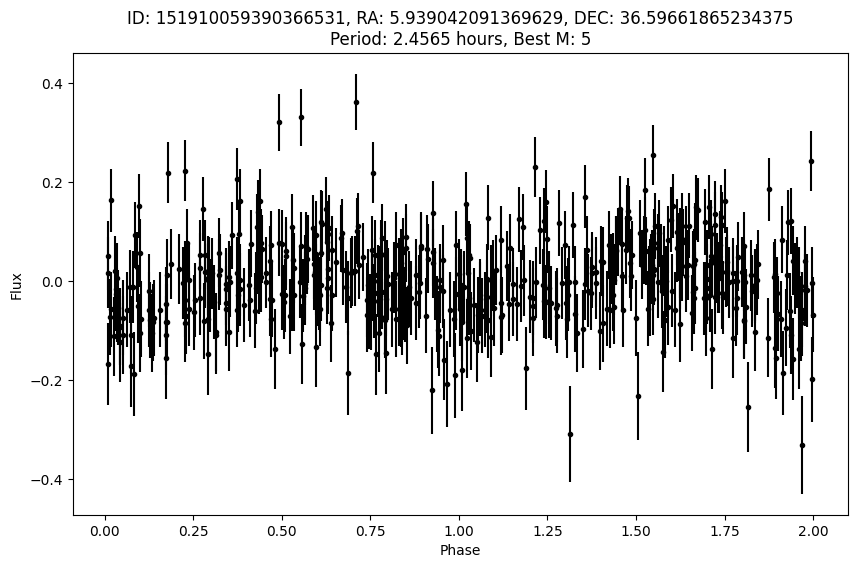

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 84 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 84 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 84 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 84 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


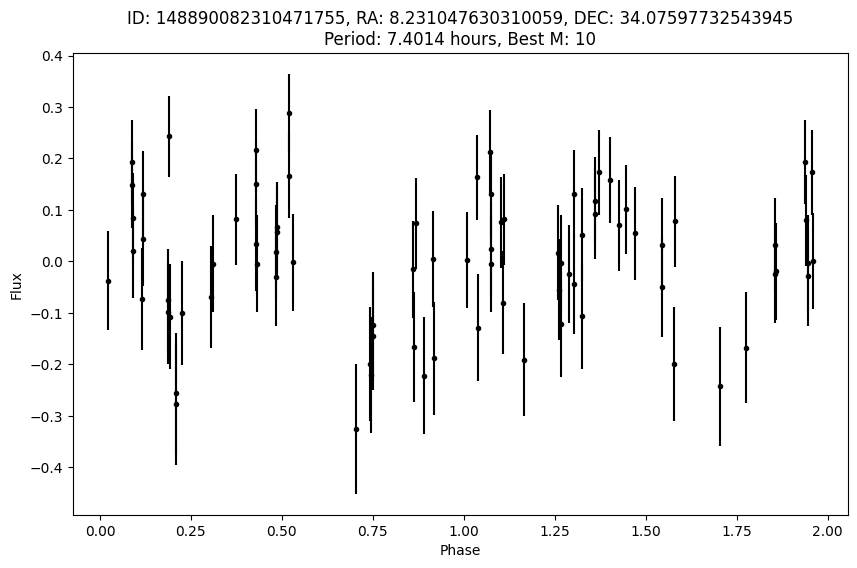

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 55 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 55 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 55 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 55 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


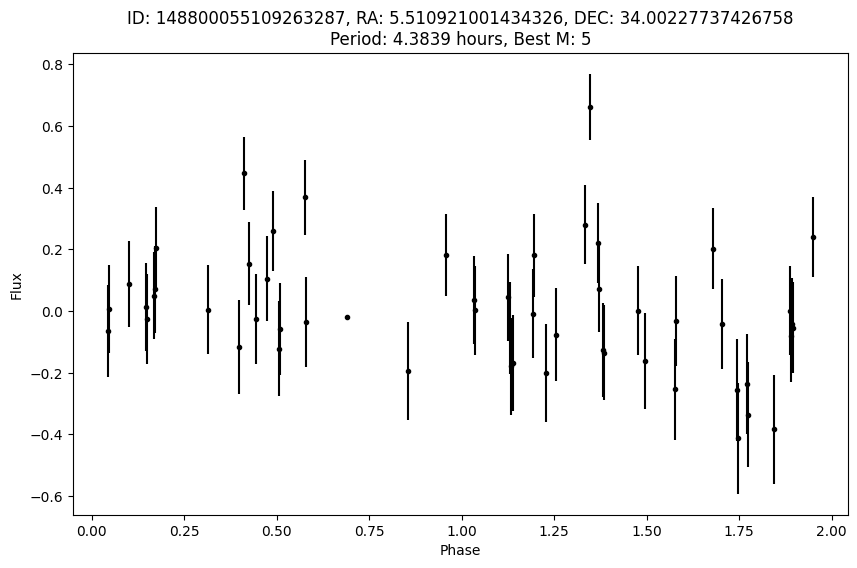

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 401 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 401 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 401 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 401 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


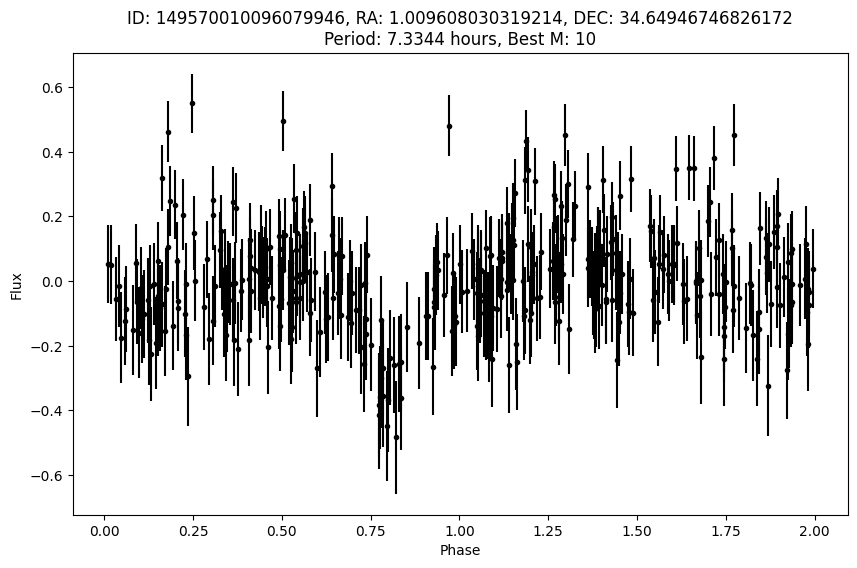

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 456 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 456 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 456 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 456 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


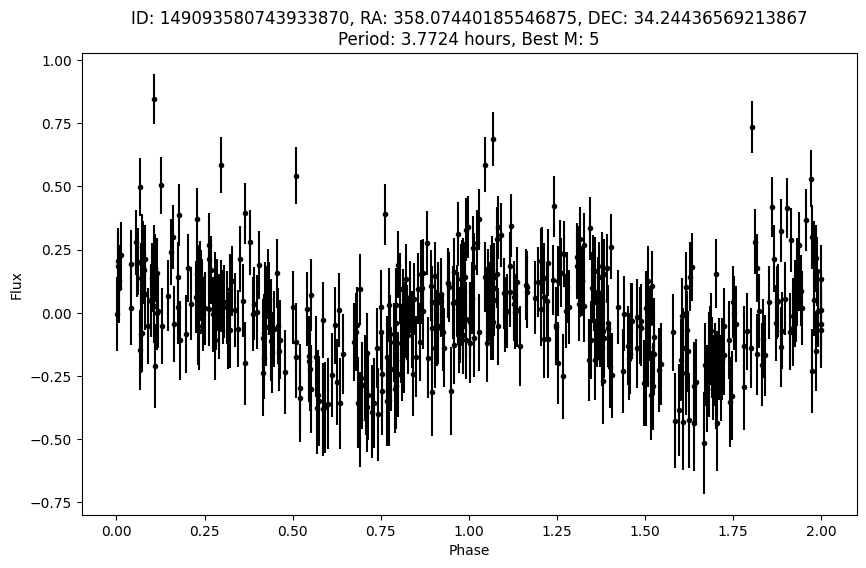

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 723 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 723 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 723 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 723 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


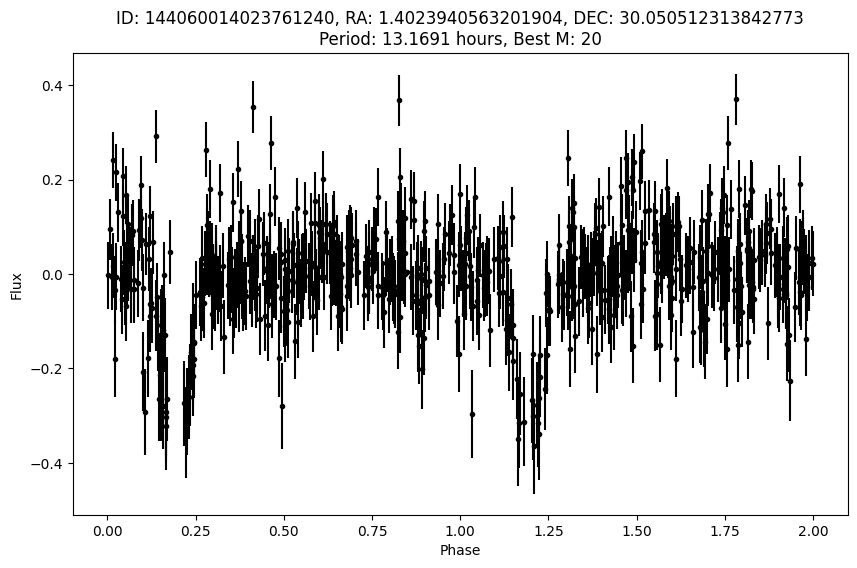

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 551 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 551 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 551 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 551 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


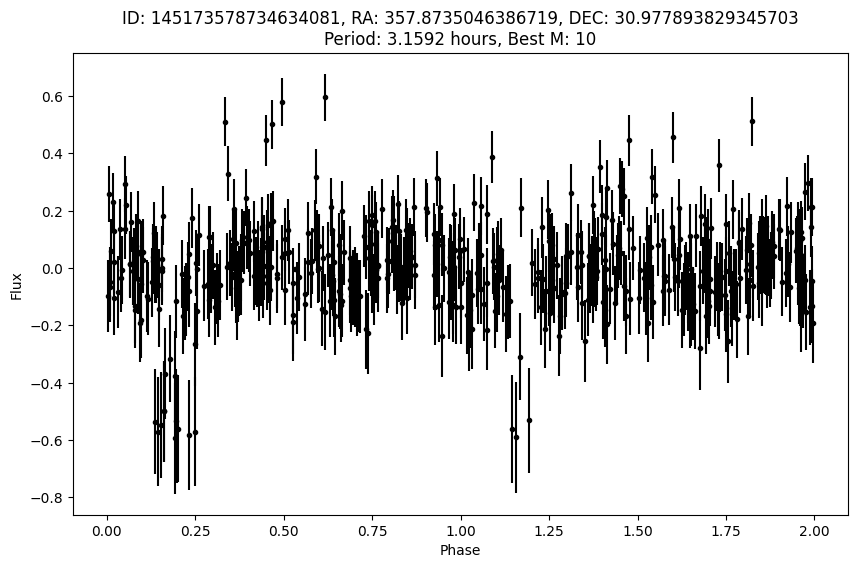

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 152 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 152 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 152 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 152 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


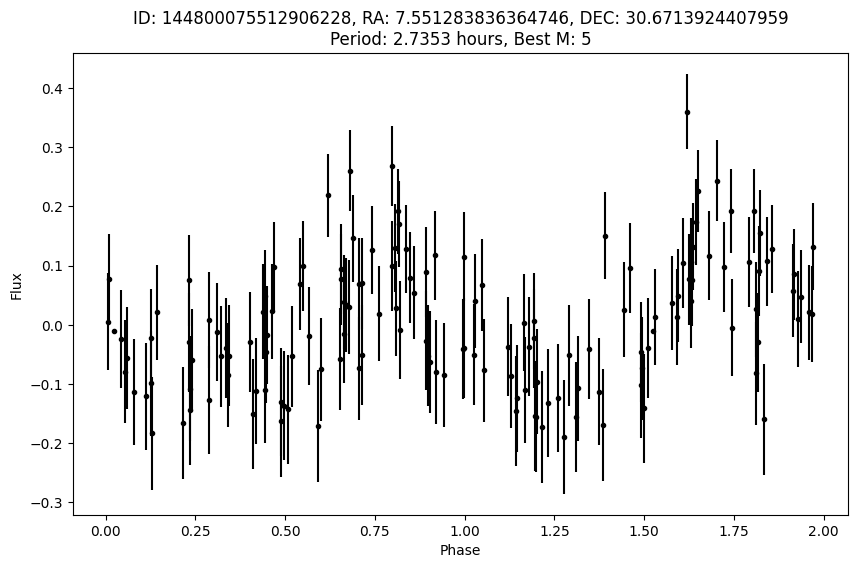

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 52 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 52 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 52 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 52 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


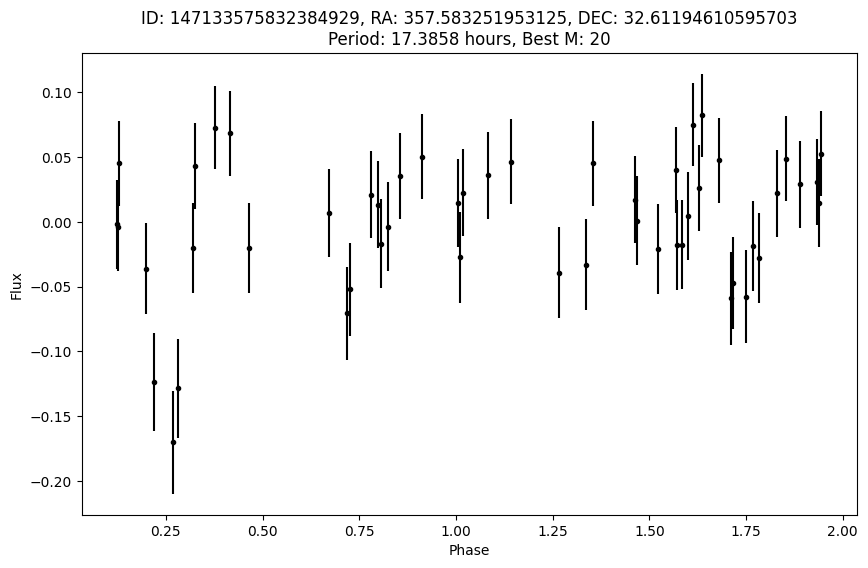

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 163 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 163 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 163 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 163 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


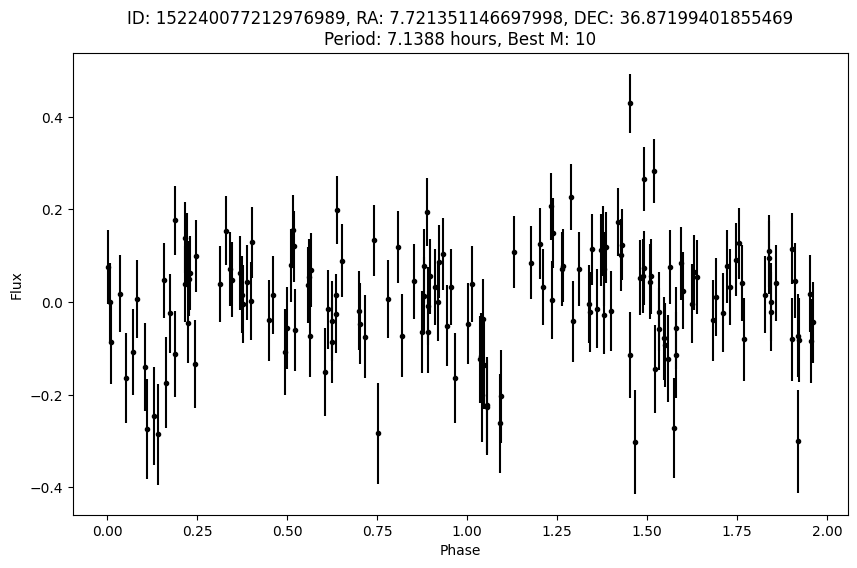

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 342 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 342 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 342 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 342 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


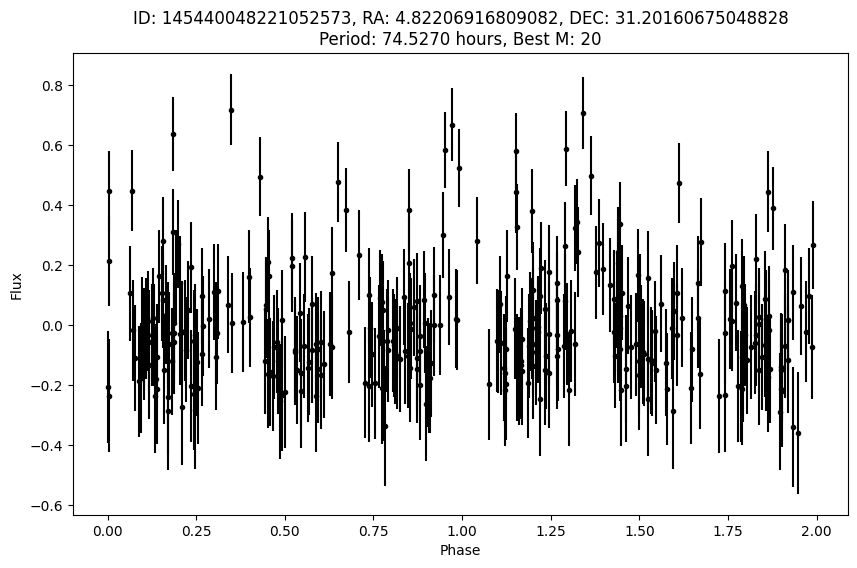

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 760 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 760 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 760 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 760 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


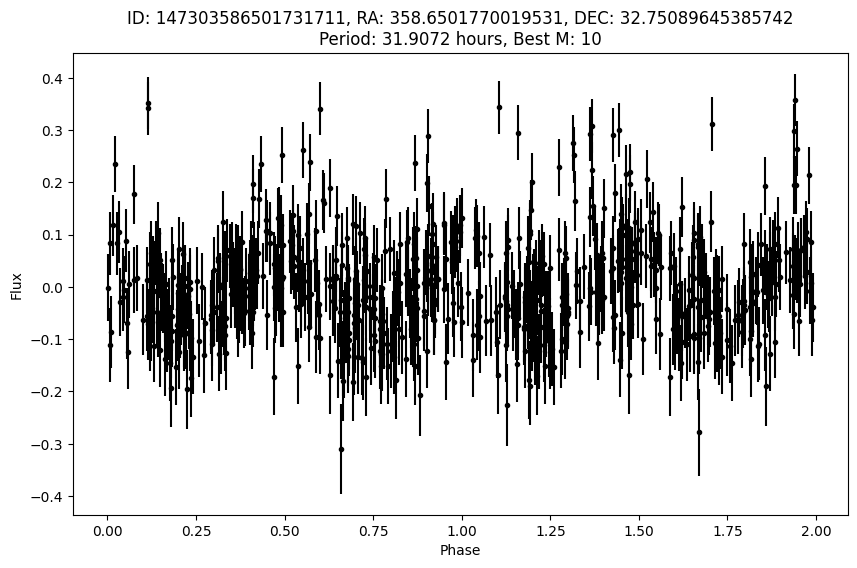

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 103 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 103 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 103 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 103 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


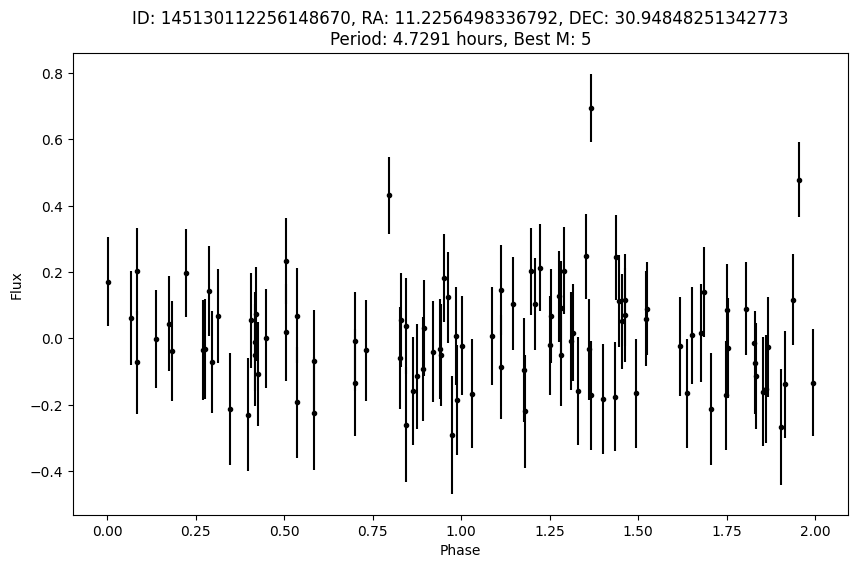

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 94 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 94 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 94 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 94 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


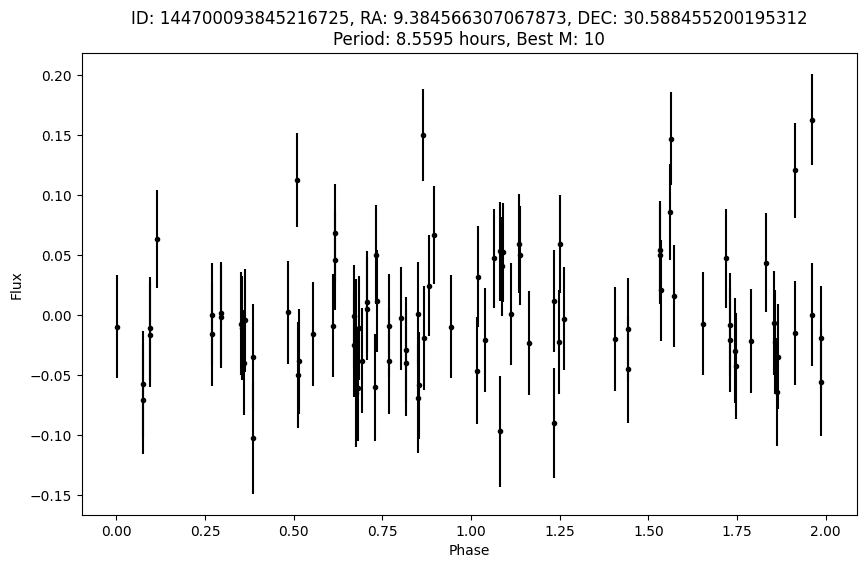

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 64 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 64 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 64 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 64 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


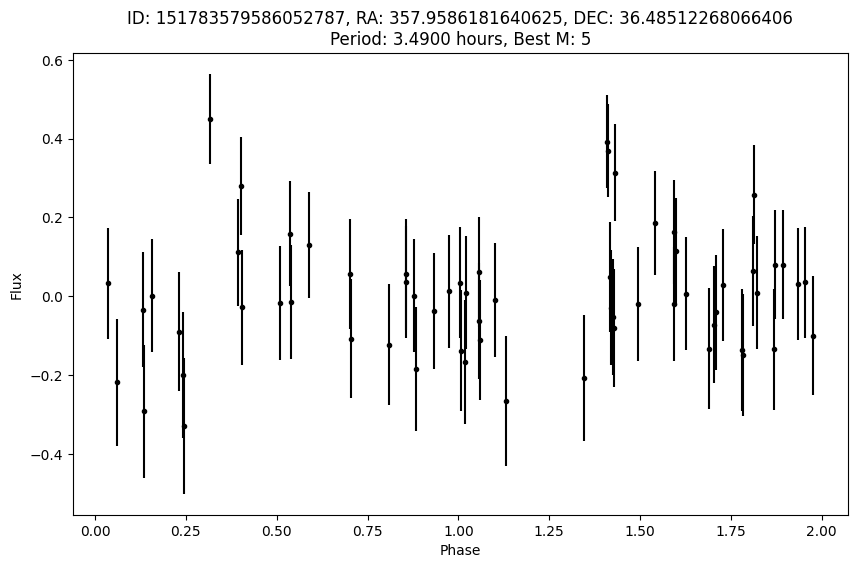

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 192 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 192 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 192 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 192 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


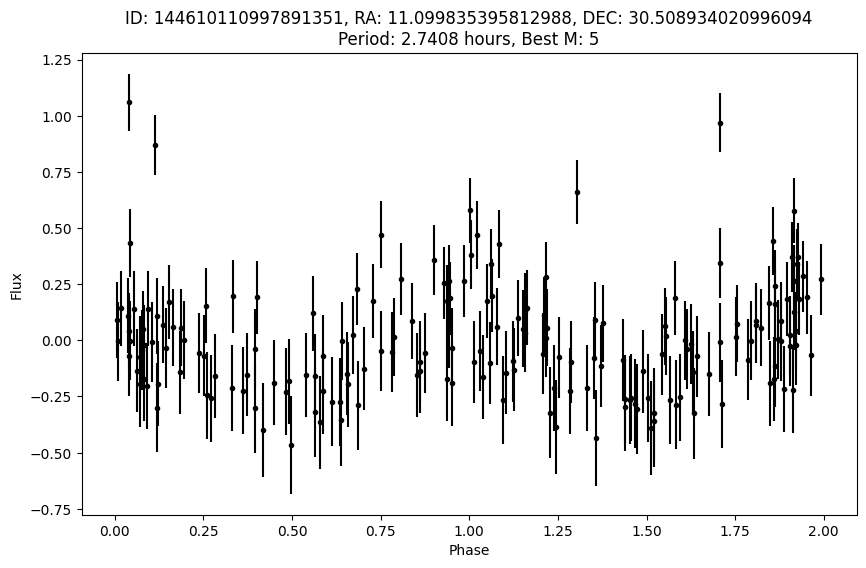

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 51 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 51 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 51 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 51 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


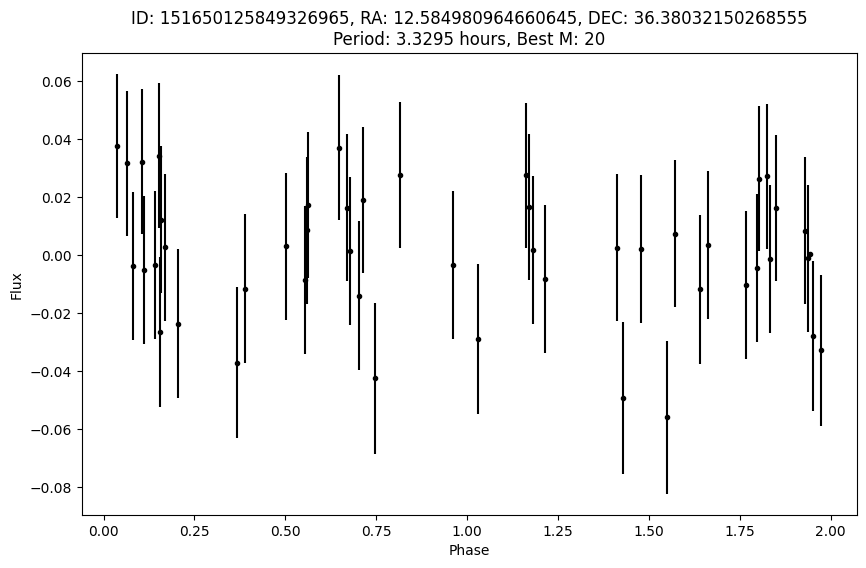

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 773 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 773 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 773 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 773 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


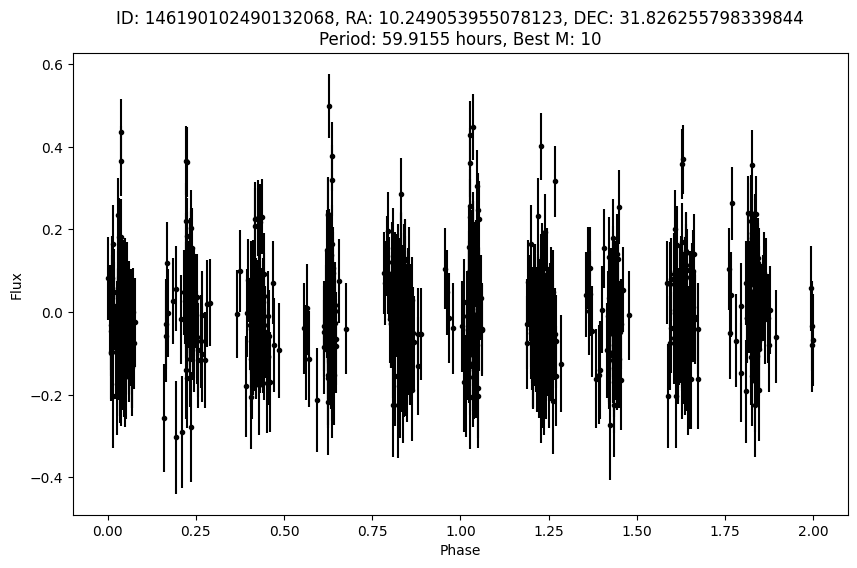

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 92 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 92 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 92 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 92 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


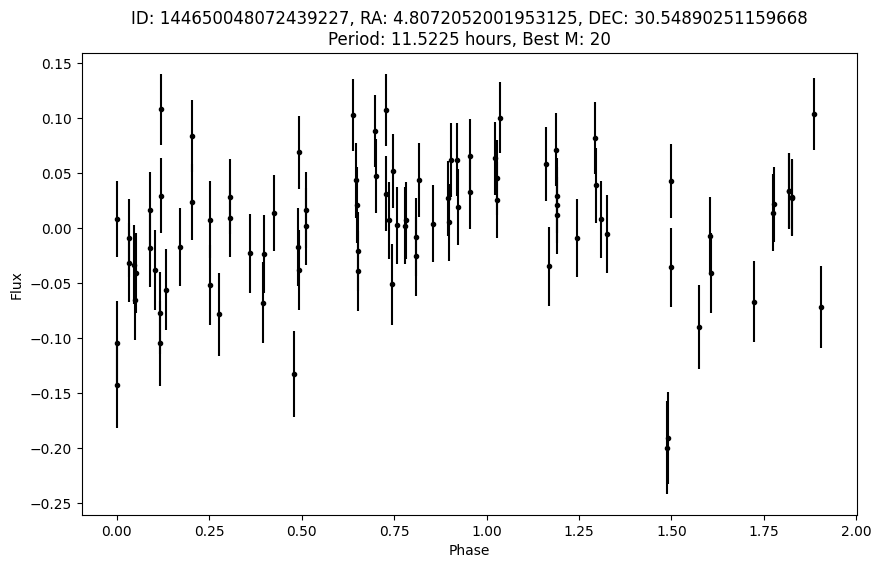

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 165 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 165 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 165 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 165 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


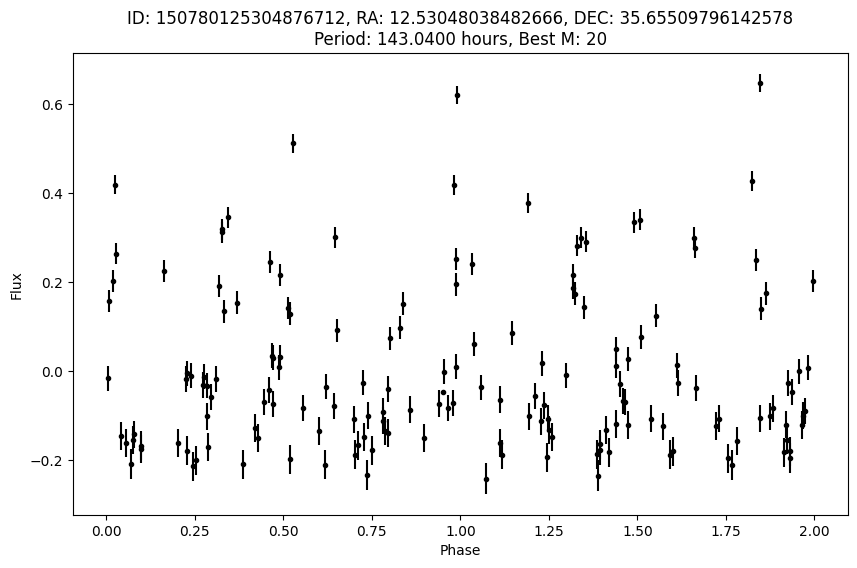

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 145 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 145 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 145 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 145 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


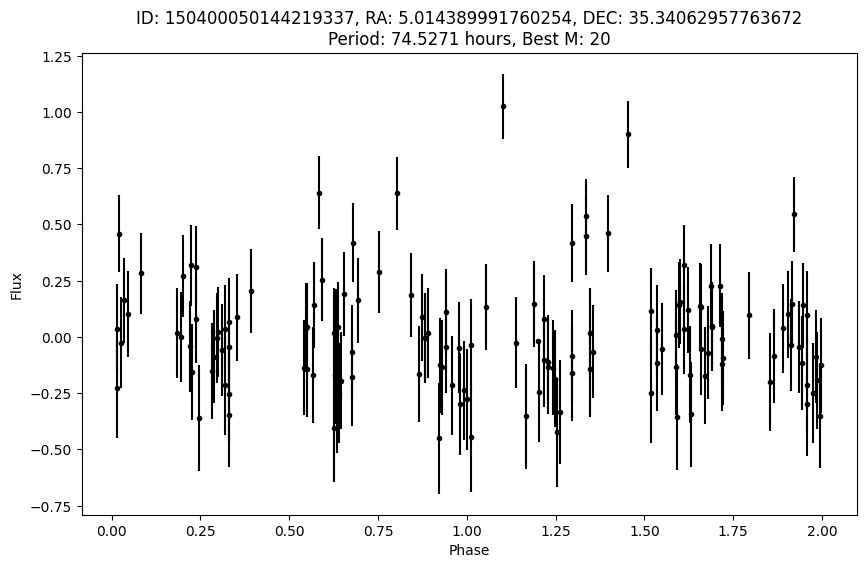

In [8]:
k = Kowalski(
    protocol="https",
    host="melman.caltech.edu",
    port=443,
    username="swhitebook",
    password="andromeda123",
    verbose=False,
    timeout=600,
)

candidates = wd_candidates
for candidate in candidates:
    result = query_kowalski(k, candidate.ra, candidate.dec, 50)
    if result is not None:
        barycorr_times, flux, ferrs = result
        times_days = barycorr_times / 86400
        phase = (times_days * candidate.freq) % 2

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.errorbar(phase, flux, yerr=ferrs, fmt='o', color='black', ms=3)
        ax.set_xlabel('Phase')
        ax.set_ylabel('Flux')
        ax.set_title(f'ID: {candidate.id}, RA: {candidate.ra}, DEC: {candidate.dec}\nPeriod: {24/candidate.freq:.4f} hours, Best M: {candidate.best_M}')
        plt.show()
    

Invidual Analysis

In [12]:
# ra = 358.8428039550781 
# dec = -26.302011489868164

ra = 4.303540229797363
dec = 32.12776565551758
min_epochs = 50

k = Kowalski(
    protocol="https",
    host="melman.caltech.edu",
    port=443,
    username="swhitebook",
    password="andromeda123",
    verbose=False,
    timeout=600,
)

barycorr_times, flux, ferrs = query_kowalski(k, ra, dec)

In [13]:
fgrid = freq_grid(barycorr_times)
# fgrid = fgrid[flag_terrestrial_freq(fgrid)]

ls_pgram = LombScargle(barycorr_times, flux, ferrs).power(fgrid)
fpw_pgram = fpw.run_fpw(barycorr_times, flux, ferrs, fgrid, 5)
fpw_pgram[np.isnan(fpw_pgram)] = 0

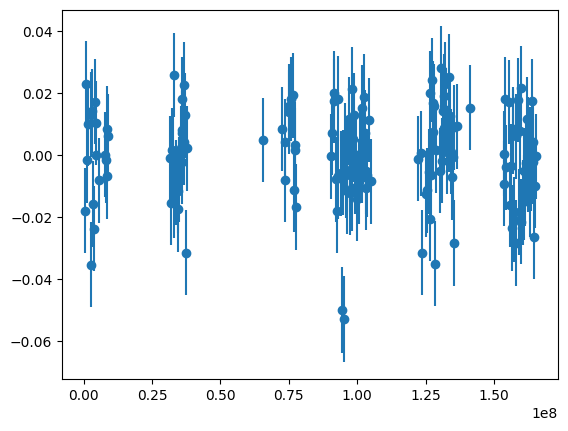

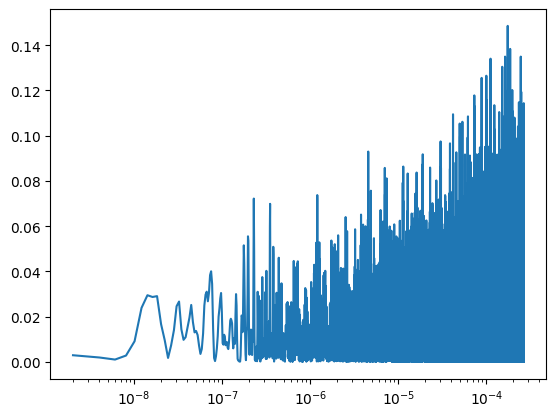

Best period: 1.4914028480706214 hours


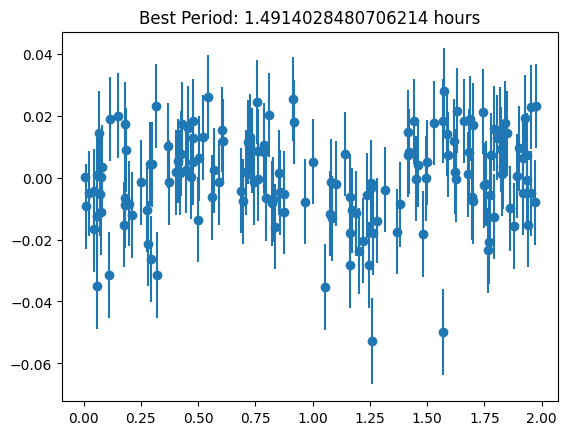

In [14]:
plt.figure()
plt.errorbar(barycorr_times, flux, yerr=ferrs, fmt='o')
plt.show()

plt.figure()
plt.plot(fgrid, ls_pgram)
# plt.plot(fgrid, fpw_pgram)
plt.xscale('log')
plt.show()

# best_period = 1/fgrid[np.argmax(ls_pgram)]
best_period = 1/fgrid[np.argmax(fpw_pgram)]
# best_period = 0.003954290821267756 * 86400
phase = (barycorr_times / best_period) % 2
print(f"Best period: {best_period / 60 / 60} hours")

plt.figure()
plt.errorbar(phase, flux, yerr=ferrs, fmt='o')
plt.title(f"Best Period: {best_period / 60 / 60} hours")
plt.show()